# Исследование психометрического распределения (кластеризации) пользователей социальной сети

Я исследую пользователя vk И его друзей.

**Цель исследования:** На основании лексической информации о пользователе, сделать вывод о его психо-типе, сгруппировать друзей пользователя по этому параметру. Отнести самого пользователя к той или иной группе. Рекомендовать пользователю друзей.

**Обоснование исследования:** Ключевым подходом к решению задачи, определяющим именно психометрическую типизацию пользователей, явлется выбор источников информации. Я опираюсь на то, что пользователь пишет о себе(осознаваемый манифест) во-первых и на скрытый лексический контекст(неосознаваемый манифест) в таких действиях пользователя как: Выбор сообществ и Выбор музыки. Такую активность(со скрытым манифестом) я описываю текстовым формальным опсианием Групп(сообществ) и жанров музыки.

**Метод исследования:** Группирую пользователей по эмбеддингам (Word2Vec) на основе полученной по вышеописанному принципу текстовой информации. 

**Примечание:** Я группирую пользователей по сообществам, рассматривая сообщество не как еидницу вектора некоего эмбединга пользователя, а строю для каждого сообщества свой эмбеддинг, таким образом два схожих сообщества будут иметь схожий эмбеддинг. И уже по этим эмбедингам строю эмбеддинг пользователя, таким образом схожие сообщества не рассматриваются как две разных единицы измерения вектора, а  имеют сконгруентное влияние.



In [ ]:
! pip install pymorphy2 transformers

import requests
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
import pymorphy2

# В финалльной версии программы вместо gensim использую BERT 
import gensim
from gensim.models import Word2Vec

from sklearn.cluster import DBSCAN

from sklearn.decomposition import IncrementalPCA
from mpl_toolkits.mplot3d import Axes3D

from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertModel, BertForSequenceClassification

from keras.preprocessing.sequence import pad_sequences
from tqdm.auto import tqdm
#from sklearn.feature_extraction.text import TfidfVectorizer

import collections
import math
from collections import Counter
import scipy as sp

     |████████████████████████████████| 61kB 4.7MB/s 
     |████████████████████████████████| 2.3MB 12.5MB/s 
     |████████████████████████████████| 8.2MB 38.8MB/s 
     |████████████████████████████████| 901kB 40.8MB/s 
     |████████████████████████████████| 3.3MB 43.2MB/s 


In [ ]:
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
TOKEN = ""
# Пользователь вк чьих друзей анализируем
USER_ID = 274013539
VER = '5.130'
friends_df_file = 'drive/MyDrive/DS-school-sber/Final/friends_df.csv'
groups_df_file = 'drive/MyDrive/DS-school-sber/Final/groups_df.csv'

# Ячейка для загрузки данных из заранее выгруженных по api файлов csv
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#%%script false

#  Работа с ранее загруженными датафреймами, без обращения к апи
friends_df = pd.read_csv(friends_df_file, index_col=0)
groups_df = pd.read_csv(groups_df_file, index_col=0)

# 1 этап - Получение всего релевантного текстового материала о пользователях
В качестве источников этого материала я беру:
1. Описание групп/сообществ на которые подписан пользователь - это ключевой(обязательный) признак.
2. Текстовые поля из описания профиля пользователя: Интересы, Цитаты, Жанры музыки и Персональная доп информация.

Сам пользователь, чьих друзей я оцениваю так же добавляется в выборку.


# 1.1 - Получение ифнормации о друзьх пользователя(одновременно об описании их сообществ)

In [ ]:
#%%script false

# Собираем DataFrame друзей по api vk
# Словарь для данных друзей
db_dict = {}
# Словарь для данных групп
groups_dict = {}

# ВК метод апи для полчения списка друзей
url_friends = f"https://api.vk.com/method/friends.get?user_ids={USER_ID}&access_token={TOKEN}&v={VER}"

# Получение информации о группах пользователя
# Расширенный вариант
url_ext_groups_sformat = f"https://api.vk.com/method/groups.get?user_id=%s&access_token={TOKEN}&extended=1&fields=description&v={VER}"
# Только Id групп
url_groups_sformat = f"https://api.vk.com/method/groups.get?user_id=%s&access_token={TOKEN}&v={VER}"

# Получение текстового описания профиля пользователя
url_bio_sformat = f"https://api.vk.com/method/users.get?user_ids=%s&fields=personal,interests,music,quotes&access_token={TOKEN}&v={VER}"

response = requests.get(url_friends)
res_dict = json.loads(response.text)
if 'response' not in res_dict:
    printf("Список друзей не доступен")
    exit
friends = res_dict['response']['items']
# Добавление самого пользователя, чьих друзей анализируем
friends.append(USER_ID)
#print(friends)

for friend in friends:
    friend_id = friend
    #response = requests.get(url_groups_sformat % friend_id)
    response = requests.get(url_ext_groups_sformat % friend_id)
    res_dict = json.loads(response.text)
    #print(res_dict)
    if 'response' not in res_dict:
        continue
    # Информация о группах пользовтаеля вляется ключевой - поэтому друзей без нее не рассматриваем
    db_dict[friend_id] = {}
    db_dict[friend_id]['groups_text'] = ''
    db_dict[friend_id]['groups'] = []
    #print(res_dict['response']['items'])
    for elem in res_dict['response']['items']:
        if 'description' in elem:
            db_dict[friend_id]['groups_text'] += elem['name'] + '. ' + elem['description'] + '. '
            db_dict[friend_id]['groups'].append(elem['id'])
            if elem['id'] not in groups_dict:
                groups_dict[elem['id']] = elem['name'] + '. ' + elem['description']
    # Получаем описание профиля пользователя
    response = requests.get(url_bio_sformat % friend_id)
    res_dict = json.loads(response.text)
    #print(res_dict)
    # Всю персональную ифномрацию конкатенируем в одну строку
    db_dict[friend_id]['personal'] = ""
    if 'response' not in res_dict:
        continue
    bio_dic = res_dict['response'][0]
    db_dict[friend_id]['first_name'] = bio_dic['first_name']
    db_dict[friend_id]['last_name'] = bio_dic['last_name']
    if 'interests' in bio_dic:
        db_dict[friend_id]['personal'] += bio_dic['interests'] + '. '
    if 'quotes' in bio_dic:
        db_dict[friend_id]['personal'] += bio_dic['quotes'] + '. '
    if 'music' in bio_dic:
        db_dict[friend_id]['personal'] += bio_dic['music'] + '. '
    if 'personal' in bio_dic and len(bio_dic['personal']):
        #print(bio_dic['personal'])
        for key in bio_dic['personal']:
            if isinstance(bio_dic['personal'][key], str) and len(bio_dic['personal'][key]):
                db_dict[friend_id]['personal'] += bio_dic['personal'][key] + '|'
    #print(db_dict[friend_id])

friends_df = pd.DataFrame.from_dict(db_dict, orient='index')

         groups_text      groups     personal  first_name   last_name
count     127.000000  127.000000   127.000000  127.000000  127.000000
mean    38340.157480  103.259843   145.661417    5.968504    7.905512
std     49904.083551  132.456055   441.132691    1.603256    2.361843
min       118.000000    1.000000     0.000000    3.000000    4.000000
25%      8620.000000   23.500000     6.000000    5.000000    7.000000
50%     18663.000000   55.000000     6.000000    6.000000    7.000000
75%     41010.000000  122.000000    84.500000    7.000000    9.000000
max    300713.000000  840.000000  3007.000000   10.000000   22.000000


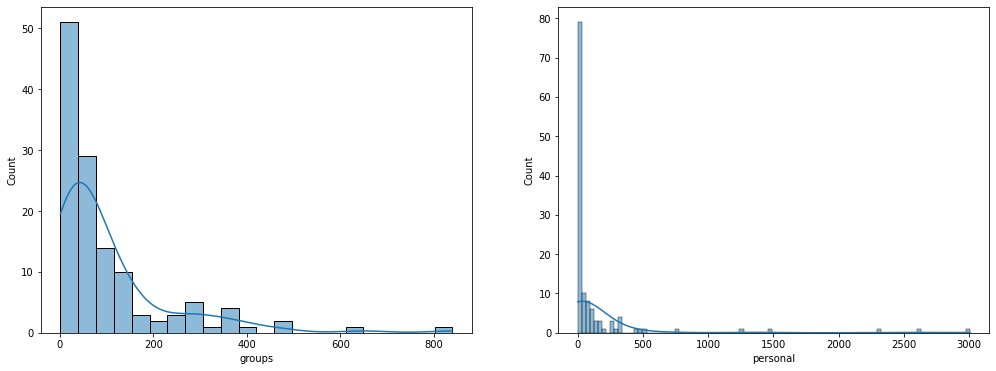

In [ ]:
#%%script false

# Статистика по собранным результатам
# Смотрю наглядно наполненность двух важных столбцов - groups и personal
def count_len(x):
    if not isinstance(x, float):
        return len(x)
    else:
        return 0

len_df = friends_df.applymap(lambda x: count_len(x))
fig,(ax1,ax2) = plt.subplots(1,2, figsize = (17,6))
sns.histplot(len_df['groups'], kde=True, ax=ax1)
sns.histplot(len_df['personal'], kde=True, ax=ax2)

print(len_df.describe())

In [ ]:
#%%script false

# Принимаю решение не включать в анализ друзей с параметрами, не удовлетворяющими условиям:
# Удаление пользователей по большому колличеству сокращает выборку в 3 раза!
# Удаление пользователей по причине отсутсвия персональной информации сокращает выборку в 2,5 раза!

MIN_DESCRIBE = 15 
MIN_GROUPS = 3
MAX_GROUPS = 100

friends_df.drop(friends_df[friends_df['groups'].map(len) < MIN_GROUPS].index, inplace=True)
# friends_df.drop(friends_df[friends_df['groups'].map(len) > MAX_GROUPS].index, inplace=True)
friends_df.drop(friends_df[friends_df['groups_text'].map(len) < MIN_DESCRIBE].index, inplace=True)

friends_df.to_csv(friends_df_file)
friends_df.applymap(lambda x: count_len(x)).describe()

,groups_text,groups,personal,first_name,last_name
count,124.000000,124.000000,124.000000,124.000000,124.000000
mean,39259.169355,105.717742,146.072581,6.000000,7.967742
std,50150.898955,133.096552,445.978894,1.607907,2.351044
min,179.000000,3.000000,0.000000,3.000000,4.000000
25%,8837.750000,24.750000,6.000000,5.000000,7.000000
50%,19589.500000,58.500000,6.000000,6.000000,7.000000
75%,42753.250000,125.250000,82.250000,7.000000,9.000000
max,300713.000000,840.000000,3007.000000,10.000000,22.000000


**Итого 124 пользователя в датасете**

# 1.2 - Получение информации о сообществах отдельно (в финальной версии ОТКЛЮЧЕНО)

In [ ]:
%%script false
# Первый вариант - сбор данных отдельными запросами

# Сбор DataFrame описания груп (для эмбеддинга групп)

# Множестов для хранения всех групп, встречающихся у пользователей
all_groups = set()

for cell in friends_df['groups']:
    for elem in cell:
        all_groups.add(elem)

#print(all_groups)
#print(len(all_groups))

# Получение текстовых данных групп для построения их эмбедингов
groups_dict = {}
url_groupinfo_sformat = f"https://api.vk.com/method/groups.getById?group_id=%s&access_token={TOKEN}&fields=description&v={VER}"
for group in all_groups:
    response = requests.get(url_groupinfo_sformat % group)
    res_dict = json.loads(response.text)
    #print(res_dict)
    if 'response' not in res_dict:
        continue
    res_dict = res_dict['response'][0]
    if 'description' in res_dict:
        groups_dict[group] = {}
        groups_dict[group]['description'] = res_dict['name'] + '|' + res_dict['description']
        print(groups_dict[group])


# 1.3 Обработка информации о группах

In [ ]:
# Второй вариант - сбор данных о группах одновременно со сбором данных о друзьях

groups_df = pd.DataFrame.from_dict(groups_dict, orient='index')
groups_df.rename(columns = {0:'description'}, inplace = True)

,description
count,9481.00000
mean,388.43276
std,538.43616
min,3.00000
25%,53.00000
50%,190.00000
75%,500.00000
max,4026.00000


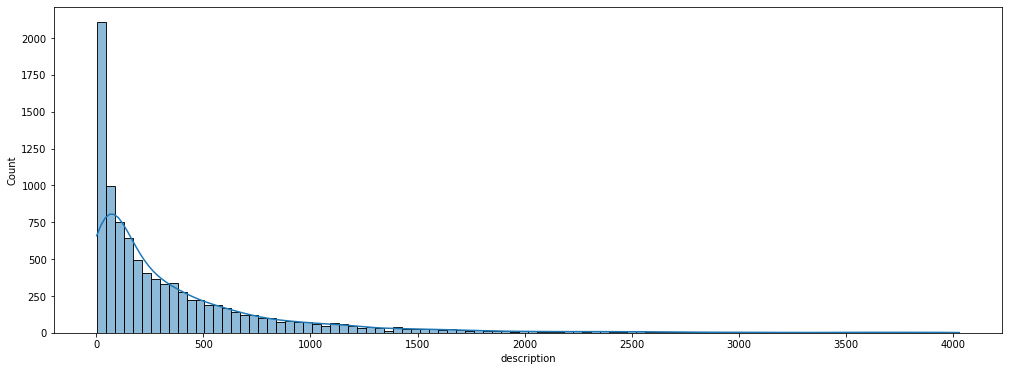

In [ ]:
#%%script false

# Статистика по сообществам

# Смотрю наглядно наполненность описания групп
len_df = groups_df.applymap(len)
fig,(ax1) = plt.subplots(1,figsize = (17,6))
sns.histplot(len_df['description'], kde=True, ax=ax1)

len_df.describe()

In [ ]:
#%%script false

# Не работаю с сообществами с коротким описанием
MIN_DESCRIPTION = 30 

groups_df.drop(groups_df[groups_df['description'].map(len) < MIN_DESCRIPTION].index, inplace=True)

groups_df.applymap(len).describe()

,description
count,7945.000000
mean,460.358087
std,560.379649
min,30.000000
25%,108.000000
50%,267.000000
75%,585.000000
max,4026.000000


**Итого 8000 групп в датасете**

In [ ]:
# Сохранение промежуточного результата
friends_df.to_csv(friends_df_file)
groups_df.to_csv(groups_df_file)

# 2 этап - Эмбеддинги сообществ.

# 2.1 - Эмбеддинги конкатенированных по пользователям сообществ (в фин весии ОТКЛЮЧЕНО)

In [ ]:
%%script false

# Функция нормализации и токенизации текста
# Выбираются только слова состоящие из букв. 
# Используется словарь русских стоп-слов. Лемматизация для токенов.

# Размер эмбеддинга w2v в gensim
EMBEDDING_SIZE = 100


def text_tokenize(text):
    lowercase_text = text.lower()
    raw_tokens = nltk.word_tokenize(lowercase_text)
    clean_tokens = [
        re.sub('[^а-я]+', '', token)
        for token in raw_tokens
    ]
    clean_tokens = [token for token in clean_tokens if token]

    morph_analyzer = pymorphy2.MorphAnalyzer(lang='ru')
    lemmatized_tokens = [
        morph_analyzer.parse(token) for token in clean_tokens
    ]
    lemmatized_tokens = [
        analysis_results[0].normal_form
        for analysis_results in lemmatized_tokens
        if analysis_results 
    ]

    stopwords = nltk.corpus.stopwords.words('russian')

    return [
        token for token in lemmatized_tokens if token not in stopwords
    ]

In [ ]:
%%script false

# Вычисляю токены текстовых описаний групп 
friends_df['groups_token'] = friends_df['groups_text'].apply(lambda x: text_tokenize(x))
# Тк токенизация имеет фильтрующее услвоие - не все группы получат токен
friends_df.drop(friends_df[friends_df['groups_token'].map(len) == 0].index, inplace=True)
friends_df

In [ ]:
%%script false

# Сохранение промежуточного результата
friends_df.to_csv(friends_df_file)

In [ ]:
%%script false

# Вычисляю Word2Vec с библиотекой Gensim

# Готовлю список токенов всего корпуса для Gensim
token_korpus = [text_tokenize(x) for x in friends_df['groups_text']]

# Учитываем смысловую связь слов на расстоянии не более 5 слов в предложении
word2vec = Word2Vec(sentences = token_korpus, size = EMBEDDING_SIZE, min_count = 1, window = 5)

In [ ]:
%%script false

# Облегчение dataframe
friends_df.drop(columns=['groups_token', 'groups_text', 'groups'], inplace = True)
friends_df

In [ ]:
%%script false

# Векторизуем тексты групп пользователя

# Полученный словарь
vocab_list = list(word2vec.wv.vocab)
# Вектора всех слов из полученного словаря
w2v_vectors = word2vec.wv.vectors
# Индексы слов из словаря
w2v_indices = {word: word2vec.wv.vocab[word].index for word in word2vec.wv.vocab}


# Фнукция возвращает вектор индексов слов предложения(текстого массива одного пользователя)
def vectorize(line): 
    words = []
    for word in line:
        try:
            w2v_idx = w2v_indices[word]
        except KeyError:
            continue
        words.append(w2v_vectors[w2v_idx])
        if words: 
            words = np.asarray(words)
            min_vec = words.min(axis=0)
            max_vec = words.max(axis=0)
            return np.concatenate((min_vec, max_vec))
        if not words:
            return None


vectors = []
for elem in token_korpus:
    vector = vectorize(elem)
    #print(len(vector))
    #print(vector)
    vectors.append(vector)

X = np.array(vectors)
np.shape(X)

# 2.2 Индивидуальные эмбеддинги каждого сообщества (BERT)

In [ ]:
# Использую BERT с словарем DeepPavlov

tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased', do_lower_case=False)

In [ ]:
# Помечаю токенами SEP и CLS как того просит BERT

groups_df['description'] = ["[CLS] " + sentence + " [SEP]" for sentence in groups_df['description']]

# Получаю токены

groups_df['tokens'] = [tokenizer.tokenize(sent) for sent in tqdm(groups_df['description'])]

# Преобразую токены в индексы по словарю bert

groups_df['ids'] = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(groups_df['tokens'])]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


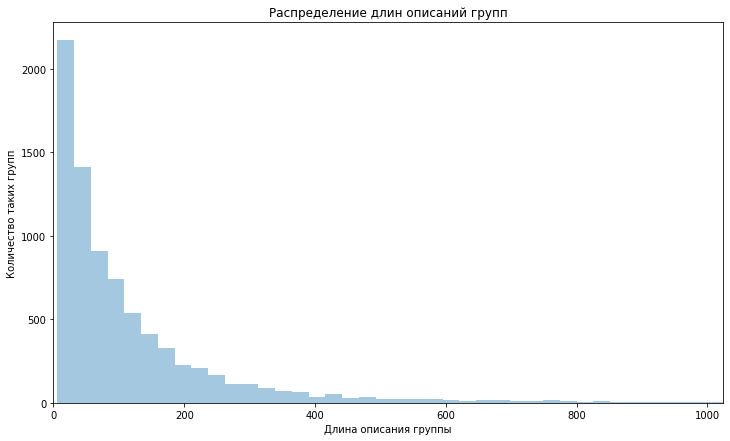

In [ ]:
# С целью приведения эмбеддингов к одному размеру исследую их длину

token_lens = [len(sent) for sent in tqdm(groups_df['ids'])]

plt.figure(figsize=(12,7))

sns.distplot(token_lens, kde=False)
plt.xlim([0, 1024])
plt.xlabel('Длина описания группы')
plt.ylabel('Количество таких групп')
plt.title('Распределение длин описаний групп')

plt.show()

In [ ]:
# "Абсолютно нормальное распределение" с точки зрения лении администраторов сообществ)

# Субьективно выбираю "стандартную" длину описания сообщества в 300 символов, описание выше этого обрезаю, меньше - делаю паддинг (и то и то с конца)
MAX_LEN = 300

padding = lambda texts: pad_sequences(texts, 
                                      maxlen=MAX_LEN, 
                                      dtype="long", 
                                      truncating="post", 
                                      padding="post"
                                     )

groups_df['norm_ids'] = list(padding(groups_df['ids']))

# 2.3 По эмбеддингам групп вычисляю эмбеддинги пользователя

# 2.3.1 TF IDF в качестве весов для усреднения

In [ ]:
%%script false # Долго вычисляет!

# Тк в токенах уже присутсвуют технические токены(SEP) да и удобнее веса расчитаь уже для вкторов после паддинга
# поэтому TfidfVectorizer из sklearn не подходит, считаю tf idf вручную

def compute_tf(text):
    tf_text = collections.Counter(text)
    for i in tf_text:
        tf_text[i] = tf_text[i]/float(len(text))
    return tf_text

def compute_idf(word, corpus):
        return math.log10(len(corpus)/sum([1.0 for i in corpus if word in i]))

def compute_tfidf(corpus):
    def compute_tf(text):
        tf_text = Counter(text)
        for i in tf_text:
            tf_text[i] = tf_text[i]/float(len(text))
        return tf_text

    def compute_idf(word, corpus):
        return math.log10(len(corpus)/sum([1.0 for i in corpus if word in i]))

    documents_list = []
    for text in corpus:
        tf_idf_dictionary = {}
        computed_tf = compute_tf(text)
        for word in computed_tf:
            tf_idf_dictionary[word] = computed_tf[word] * compute_idf(word, corpus)
        documents_list.append(tf_idf_dictionary)
    return documents_list

tokens_list = groups_df['norm_ids'].to_list()

print(compute_tfidf(tokens_list))

**Для каждого пользователя нахожу эмбеддинг путем усреднения эмбеддингов его групп**

In [ ]:
# Функция нахождения среднего эмбеддинга по списку групп
def count_mean_emb(friend_groups_list, groups_df):

    # Тк некоторые группы были удалены из краткости описания - выбираем их аккуратно
    friend_groups_df = groups_df.loc[groups_df.index.intersection(friend_groups_list)]

    arr = np.array(friend_groups_df['norm_ids'])
    return arr.mean()

friends_df['emb'] = friends_df['groups'].apply(lambda x: count_mean_emb(x, groups_df))

# Получаем array
X = friends_df['emb'].to_numpy()
X = np.vstack(X)
X

array([[  101, 42126, 23178, ...,  1250,  1092,  2102],
       [  101, 47202, 22027, ...,  2407,   298,     5],
       [  101, 49611, 28380, ...,    14, 12945,  2587],
       ...,
       [  101, 72544, 30986, ...,    61,  2421,   458],
       [  101, 37658, 18297, ..., 11989, 10299,   135],
       [  101, 36416, 18522, ...,  2281,   866,   536]])

# 3 этап - Кластеризация пользователей по эмбедингам сообществ

In [ ]:
# Тк мы не можем предположить сколько классов нужно получить, используем DBSCAN
# Метрика косинуса наиболее подходящая для сравнения векторов

dbscan = DBSCAN(metric='cosine', eps=0.07, min_samples=3)
cluster_labels = dbscan.fit_predict(X)
friends_df['cluster'] = cluster_labels

In [ ]:
# Посмотрим на распределение пользователей по группам
friends_df.groupby('cluster').count()

,groups_text,groups,personal,first_name,last_name,emb
cluster,,,,,,
-1,31,31,31,31,31,31
0,93,93,93,93,93,93


***Получаю два стабильных класса***

CPU times: user 11.4 ms, sys: 25.1 ms, total: 36.5 ms
Wall time: 26.2 ms
CPU times: user 908 µs, sys: 930 µs, total: 1.84 ms
Wall time: 1.23 ms


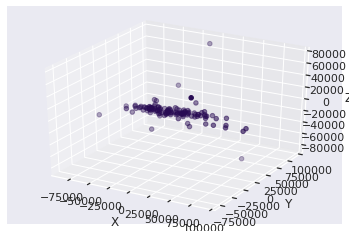

In [ ]:
# Визуализация кластеризации
# Тк эмбединги поользователей имеют размерность 200, а посмортеть кластеризацию на картинке очень хочется
# Снижаем размерность до 3х!) Использую pca

icpa = IncrementalPCA(n_components=3, batch_size=16)
get_ipython().magic('time icpa.fit(X) #demo =')
get_ipython().magic('time ddd = icpa.transform(X)')
xs, ys, zs = ddd[:, 0], ddd[:, 1], ddd[:, 2]

# График рисую очегь условный
fig = plt.figure()
sns.set(palette='inferno')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [ ]:
# Список пользователей по группам

set_labels = set()
for label in cluster_labels:
    set_labels.add(label)
for label in set_labels:
    print(label)
    print(friends_df[friends_df['cluster'] == label][['first_name', 'last_name']])
    print()

0
          first_name      last_name
24770       Валентин      Афанасьев
557179         Ренат          Хузин
1176530    Александр           Зуев
1213366        Павел        Сураков
1320231       Eugene          Paley
...              ...            ...
290622438      Дарья      Бредихина
305568250     Алинка        Малинка
451730086    Дмитрий       Степанов
500780619    Алексей           Юлия
513141277    Альбина  Акрамутдинова

[93 rows x 2 columns]

-1
          first_name     last_name
617195       Алексей        Ефимов
1129781         Олег      Самойлов
1517450       Андрей       Сапунов
2240308       Руслан        Бакеев
4259844        Роман   Котельников
4458272        Ильяс     Исмагилов
7158801        Марат        Якупов
7837866    Анастасия      Аксенова
8818308       Василь       Камалов
14563197     Эльвира  Салимджанова
26555379       Марат       Низамов
26935430      Рамиль      Хусаинов
28836714   Александр     Белокуров
29196491    Искандер        Ягудин
32450422      

# 4 этап - Кластеризация пользователей по описанию профиля

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


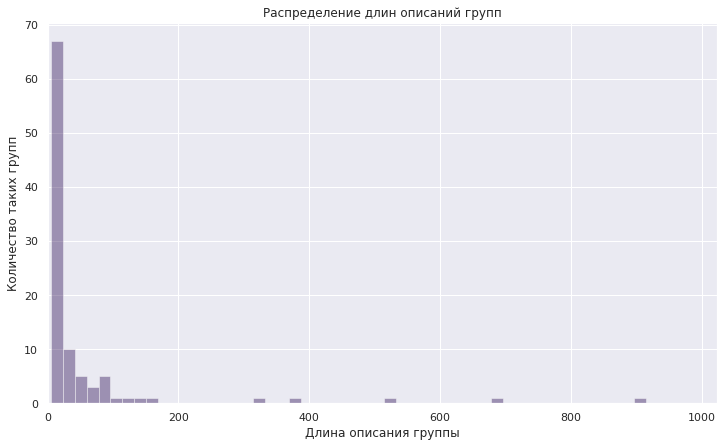

,cluster
count,99.000000
mean,-0.272727
std,0.447628
min,-1.000000
25%,-1.000000
50%,0.000000
75%,0.000000
max,0.000000


In [ ]:
# Не рассматриваю пользователей с коротким описанием

friends_df.drop(friends_df[friends_df['personal'].map(len) < 5].index, inplace=True)

# Помечаю токенами SEP и CLS как того просит BERT

friends_df['personal'] = ["[CLS] " + sentence + " [SEP]" for sentence in friends_df['personal']]

# Получаю токены

friends_df['personal_token'] = [tokenizer.tokenize(sent) for sent in tqdm(friends_df['personal'])]

# Преобразую токены в индексы по словарю bert

friends_df['ids'] = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(friends_df['personal_token'])]

# С целью приведения эмбеддингов к одному размеру исследую их длину

token_lens = [len(sent) for sent in tqdm(friends_df['ids'])]

plt.figure(figsize=(12,7))

sns.distplot(token_lens, kde=False)
plt.xlim([0, 1024])
plt.xlabel('Длина описания группы')
plt.ylabel('Количество таких групп')
plt.title('Распределение длин описаний групп')

plt.show()

friends_df.describe()

In [ ]:
# Делаю паддинг

MAX_LEN = 100

padding = lambda texts: pad_sequences(texts, 
                                      maxlen=MAX_LEN, 
                                      dtype="long", 
                                      truncating="post", 
                                      padding="post"
                                     )

friends_df['norm_ids'] = list(padding(friends_df['ids']))

# Получаю array
X2 = friends_df['norm_ids'].to_numpy()
X2 = np.vstack(X2)
X2

array([[   101, 105297,    128, ...,      0,      0,      0],
       [   101,    132,    132, ...,      0,      0,      0],
       [   101,  14055,   3049, ...,      0,      0,      0],
       ...,
       [   101,    132,    132, ...,      0,      0,      0],
       [   101,    132,    132, ...,      0,      0,      0],
       [   101,  48575,   3817, ...,      0,      0,      0]])

Видно, что достаточное колличество подходящего текстовго описания для токенизации имеет только половина пользователей

In [ ]:
# DBSCAN

dbscan = DBSCAN(metric='cosine', eps=0.07, min_samples=4)
profile_cluster_labels = dbscan.fit_predict(X2)
friends_df['profile_cluster'] = profile_cluster_labels

# Посмотрим на распределение пользователей по группам
friends_df.groupby('profile_cluster').count()

,groups_text,groups,personal,first_name,last_name,emb,cluster,personal_token,ids,norm_ids
profile_cluster,,,,,,,,,,
-1,55,55,55,55,55,55,55,55,55,55
0,44,44,44,44,44,44,44,44,44,44


***При кластеризации по описанию профиля так же получается 2 класса***

In [ ]:
# Список пользователей по группам

set_labels = set()
for label in profile_cluster_labels:
    set_labels.add(label)
for label in set_labels:
    print(label)
    print(friends_df[friends_df['profile_cluster'] == label][['first_name', 'last_name']])
    print()

0
           first_name               last_name
557179          Ренат                   Хузин
1517450        Андрей                 Сапунов
2836906       Алексей              Туливетров
3836827          Влад                Кузнецов
4458272         Ильяс               Исмагилов
4795571         Расим                 Латыпов
4878796        Лейсэн                Зарипова
5274748     Анастасия               Кузнецова
5494433         Алина  Баймуратова-Хайруллина
7158801         Марат                  Якупов
8658170         Мария                Казанова
9007592     Владислав                  Фирсов
9921730          Саня                   Билан
9933987          Юлия               Бессонова
10689686       Эдуард                Николаев
11806995        Денис                Пасынков
11817947       Максим                 Семенов
14563197      Эльвира            Салимджанова
17268263          Яна                 Аверина
17596031    Александр                   Попов
23326616       Ильшат           

# 5 этап - Оценка качества

# 5.1 Сравнение близости двух способ кластеризации
Я разделил пользователе на группы по эмбеддингам их сообществ и по эмбеддингам описаний их профиля. Теперь сравню насколько эти две классификации схожи!

In [ ]:
friends_df['quality'] = abs(friends_df['cluster'] - friends_df['profile_cluster'])
error = friends_df['quality'].sum() / friends_df['quality'].count()
error

0.5454545454545454

**К сожалению классификации по профилю и по группам не конгруентны. Поэтому вторую оценку качества будем делать по базовой кластеризации (по сообществам)**

# 5.2 Оценка разброса эмбеддингов пользователей от эталонного эмбединга представителя их группы
Алгоритм метрики основан на субьективном выборе центров кластеров и оценки разброса эвклидовых расстояний внтури кластеров.

In [ ]:
etalon0_id = 24770
etalon1_id = 14275236     

def euclid_metric(vec1, vec2):
    delta = vec1/sp.linalg.norm(vec1) - vec2/sp.linalg.norm(vec2)
    return sp.linalg.norm(delta)

emb1 = friends_df.loc[etalon1_id]['emb']
emb0 = friends_df.loc[etalon0_id]['emb']
sum0 = 0
sum1 = 0

group0 = friends_df[friends_df['cluster'] == 0]['emb'].to_list()
for elem in group0:
    sum0 += euclid_metric(elem, emb0)

group1 = friends_df[friends_df['cluster'] == -1]['emb'].to_list()
for elem in group1:
    sum1 += euclid_metric(elem, emb1)

print('Среднее отклонение(ошибка) от эталона:\nВ первой группе: ', sum0 / len(group0), '\nВо второй: ', sum1 / len(group1))

Среднее отклонение(ошибка) от эталона:
В первой группе:  0.30855251296347436 
Во второй:  0.6162401228960045


# 6 - Выводы.
С практической точки зрения я оцениваю резалуьтат как удовлетворительный.
Гипотеза о наличии психологической метрики, обуславливающей стиль текстов пользовател его характером требует более тащетльного исследования.

Я искал корелляцию между текстами, описывающими сообщества пользователя и текстом написанным собственноручно пользователем в качестве своего описания профиля.

На основе такой корелляции я хотел сгруппировать пользователей и сделать вывод о их стабильном внутри каждой группы психотипе.

Класстеризация пользователей по текстам описаний сообществ и описаний личных профилей оказалась неконгруэнтной.

Кластеризация же пользоватлей по эмбеддингам сообществ показала доверительный результат. В частном слуае группа пользователей из 100+ человек была разделена на две подгруппы с устойчивой корелляцией внутри группы.